<a href="https://colab.research.google.com/github/Thaer-Sahmoud/IUG_NLP/blob/master/COA_image_Caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# !pip install pycocotools
from pycocotools.coco import COCO # COCO python library
import numpy as np
import time
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import string
import cv2
import os
from pickle import dump, load
import json
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from tensorflow.keras.models import Model, load_model
from tqdm.notebook import tqdm
from datetime import date
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
print("Done:  {}".format(date.today()))

Done:  2022-10-11


In [5]:
# Download the needed datasets 
if os.path.isfile("annotations_trainval2017.zip") == False:
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip annotations_trainval2017.zip

if os.path.isfile("annotations_trainval2017.zip") == False:
  !wget http://images.cocodataset.org/zips/val2017.zip
  !unzip val2017.zip

# download Stopwards from nltk library
nltk.download("stopwords")

print("Done:  {}".format(date.today()))

--2022-10-11 05:29:29--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.136.9
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.136.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.5MB/s    in 2.5s    

2022-10-11 05:29:32 (96.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  
Done:  2022-10-11


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# load dataset into memory (we can use multithreading here)
coco=COCO("annotations/instances_train2017.json")

cats = coco.loadCats(coco.getCatIds())
maincategories = list(set([cat['supercategory'] for cat in cats]))

print("Number of main categories: ", len(maincategories))
print("List of main categories: ", maincategories)

subcategories = [cat['name'] for cat in cats]

print("Number of sub categories: ", len(subcategories))
print("List of sub categories: ", subcategories)

catIds = coco.getCatIds(catNms=subcategories)

subcategories_Ids = dict()
for i in range(0,len(subcategories)):
    subcategories_Ids[subcategories[i]] = catIds[i]

print("Sub categories with IDs :",subcategories_Ids)

subcategories_imageIds = dict()

for i in range(0,len(catIds)):
    imgIds = coco.getImgIds(catIds=catIds[i])
    img = []
    for j in imgIds: 
        img.append(j)
    subcategories_imageIds[subcategories[i]] = img
    
print("Sub categories with Image IDs :",len(subcategories_imageIds))

length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in each sub categories: ", length_dict)

train_cats = subcategories_imageIds['bicycle'] + subcategories_imageIds['airplane']
imgIdss = coco.getImgIds(imgIds = train_cats)
print("Total Images: ", len(imgIdss))

print("Done:  {}".format(date.today()))

loading annotations into memory...
Done (t=22.51s)
creating index...
index created!
Number of main categories:  12
List of main categories:  ['food', 'outdoor', 'vehicle', 'electronic', 'appliance', 'kitchen', 'furniture', 'sports', 'indoor', 'person', 'accessory', 'animal']
Number of sub categories:  80
List of sub categories:  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv

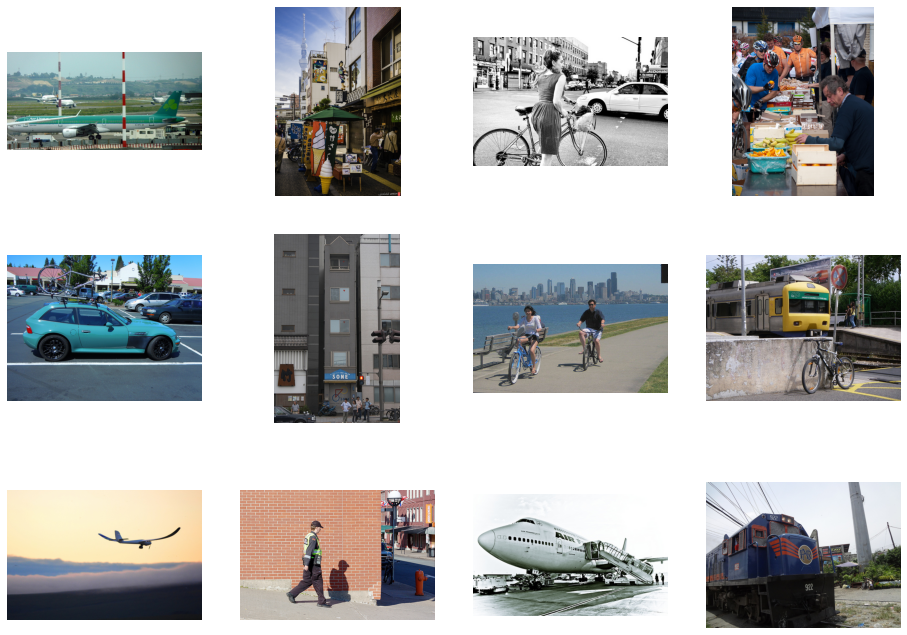

Done:  2022-10-11


In [13]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

next_pix = imgIdss
random.shuffle(next_pix)

for i, img_path in enumerate(next_pix[0:12]):
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')
    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)

plt.show()

print("Done:  {}".format(date.today()))

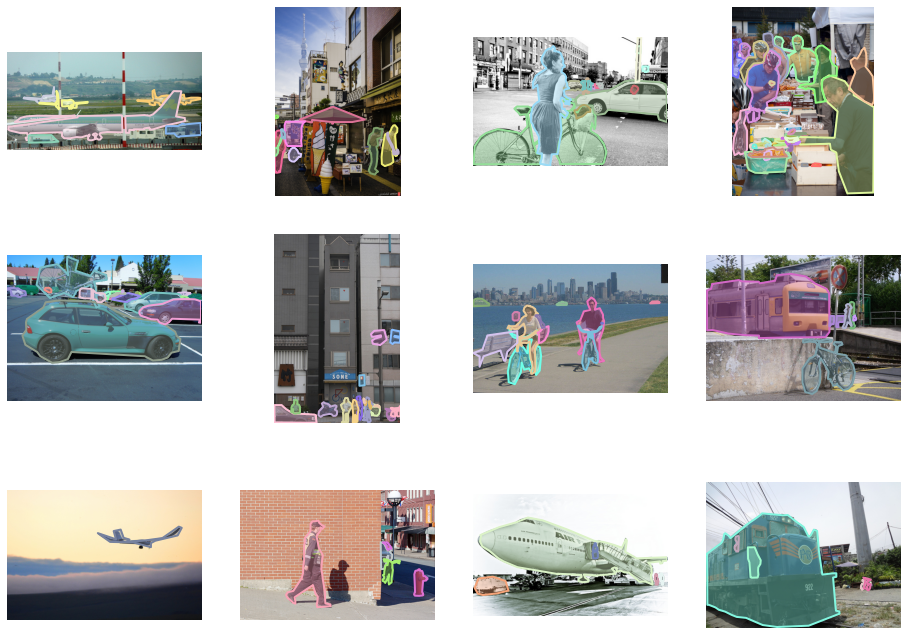


Done:  2022-10-11


In [16]:
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    # print(anns)
    coco.showAnns(anns)
    

plt.show()

print("\nDone:  {}".format(date.today()))

loading annotations into memory...
Done (t=11.45s)
creating index...
index created!


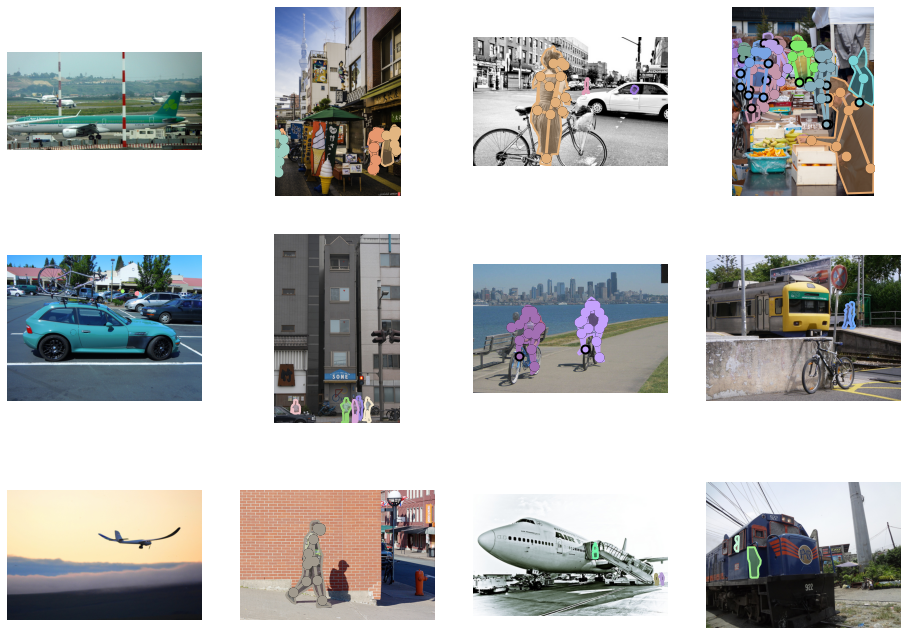


Done:  2022-10-11


In [17]:
coco_kps=COCO("annotations/person_keypoints_train2017.json")

fig = plt.gcf()
fig.set_size_inches(16, 16)

for i, img_path in enumerate(next_pix[0:12]):
    
    sp = plt.subplot(4, 4, i + 1)
    sp.axis('Off')

    img = coco.loadImgs(img_path)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I)
    annIds = coco_kps.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco_kps.loadAnns(annIds)
    coco_kps.showAnns(anns)
    

plt.show()

print("\nDone:  {}".format(date.today()))

In [ ]:
# annFile = "annotations/captions_train2017.json"


loading annotations into memory...
Done (t=1.25s)
creating index...
index created!


loading annotations into memory...
Done (t=1.22s)
creating index...
index created!
A large green airplane in a stationary position.
A green Air Plane is stopped in its station. 
A jumbo jet airplane in a holding place on a runway.
A airplane that is sitting on a runway.
a very  large green airplane on a runway


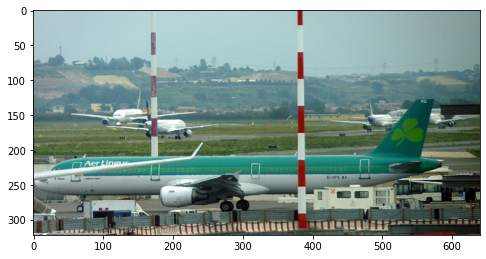


Done:  2022-10-11


In [18]:
coco_caps=COCO("annotations/captions_train2017.json")
img = coco.loadImgs(next_pix[0])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()
print("\nDone:  {}".format(date.today()))

A street with various signage and people in shops.
A busy street with a variety of vendors and colorful tents.
A large ice cream cone sits next to an umbrella on a city street.
An outdoor stand that serves ice cream on an Asian street.
A crowded street lined with vendors and people.


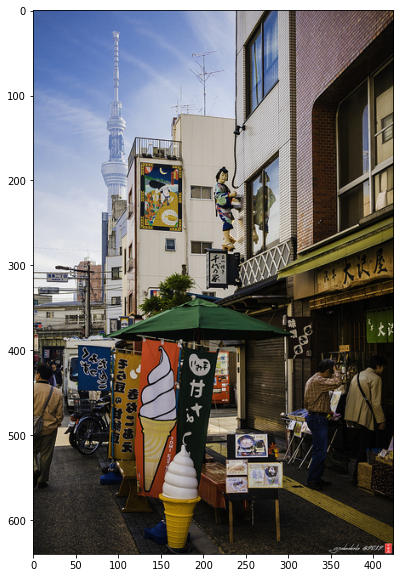


Done:  2022-10-11


In [19]:
img = coco.loadImgs(next_pix[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()
print("\nDone:  {}".format(date.today()))

A jetliner sitting on top of a tarmac with a staircase on it.
a large plane is sitting on a runway
This picture shows how big most passenger airplanes are.
An Air France passenger jet is parked on a tarmac.
An old air plane stopped at a tarmac for passengers to enter.



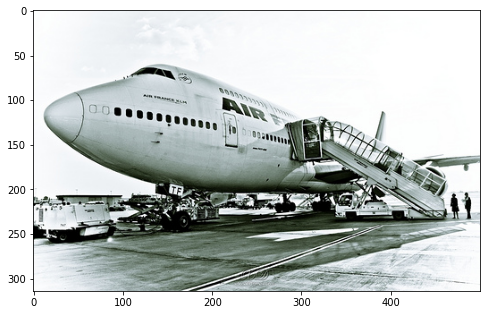


Total images for training:  6221

Done:  2022-10-11


In [22]:
img = coco.loadImgs(next_pix[10])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

print("\nTotal images for training: ", len(imgIdss))
print("\nDone:  {}".format(date.today()))

In [23]:
dataset = dict()
imgcaptions = []

for imgid in imgIdss:
    img = coco.loadImgs(imgid)[0]
    annIds = coco_caps.getAnnIds(imgIds=img['id']);
    anns = coco_caps.loadAnns(annIds)
    imgcaptions = []
    for cap in anns:
        
        # Remove punctuation
        cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
        
        # Replace - to blank
        cap = cap.replace("-"," ")
        
        # Split string into word list and Convert each word into lower case
        cap = cap.split()
        cap = [word.lower() for word in cap]
        
        # join word list into sentence and <start> and <end> tag to each sentence which helps 
        # LSTM encoder-decoder model while training.
        
        cap = '<start> ' + " ".join(cap) + ' <end>'
        imgcaptions.append(cap)
        
    dataset[img['coco_url']] = imgcaptions 
    
    
print("Length of Dataset: ",len(dataset))
print(dataset['http://images.cocodataset.org/train2017/000000047084.jpg'])
#dataset
print("\nDone:  {}".format(date.today()))

Length of Dataset:  6221
['<start> a jumbo jet plane connected to a boarding deck <end>', '<start> a large blue passenger plane sits on the tarmac at the airport <end>', '<start> a blue commercial airplane parked at a jet way <end>', '<start> a large airplane that is sitting out on the runway <end>', '<start> a blue plane at the airport being offloaded <end>']

Done:  2022-10-11


In [24]:
from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values())) #[[1,3],[4,8]] = [1,3,4,8]

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("Bicycle ID: ", tokenizer.word_index['bicycle'])
print("Airplane ID: ", tokenizer.word_index['airplane'])
print("\nDone:  {}".format(date.today()))
# print(tokenizer.word_index)

Vocabulary length:  6410
Bicycle ID:  28
Airplane ID:  13

Done:  2022-10-11


# **That Part need to be done via multithreading**


In [25]:
model = Xception(include_top=False, pooling='avg')

start_t = time.time()
image_features = {}
for img in tqdm(dataset.keys()):
    image = io.imread(img)
    if image.ndim != 3:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    # Resize each image size 299 x 299
    image = cv2.resize(image,(299,299))
    image = np.expand_dims(image, axis=0)
    # Normalize image pixels
    image = image/127.5
    image = image - 1.0
    # Extract features from image
    feature = model.predict(image)
    image_features[img] = feature
end_t = time.time()
print("Image features length: ", len(image_features))

print("\nDone:  {}\nIt takes time = {}".format(date.today(),end_t - start_t))

83697664/83683744 [==============================] - 1s 0us/step


  0%|          | 0/6221 [00:00<?, ?it/s]

Image features length:  6221

Done:  2022-10-11
It takes time = 3815.169634103775


In [ ]:
image_features['http://images.cocodataset.org/train2017/000000047084.jpg'].shape

NameError: ignored

In [ ]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(dataset)
max_length

In [ ]:
#create input-output sequence pairs from the image description.

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():

            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output
            
    return np.array(X1), np.array(X2), np.array(y)

In [ ]:
from keras.utils import plot_model

# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(total_words, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
print('Dataset: ', len(dataset))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)
epochs=1
steps = len(dataset)

# making a directory models to save our models
import os
os.mkdir("models")

for i in range(epochs):
    generator = data_generator(dataset, image_features, tokenizer, max_length)
    model.fit(generator, epochs=5, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


img_paths = ["../input/cocods/val2017/val2017/000000001761.jpg",
            "../input/cocods/val2017/val2017/000000022396.jpg",
            "../input/cocods/val2017/val2017/000000098520.jpg",
            "../input/cocods/val2017/val2017/000000101762.jpg",
            "../input/cocods/val2017/val2017/000000224051.jpg"]

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text


#max_length = 46

model = load_model('./models/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_paths[0], xception_model)
img = Image.open(img_paths[0])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

OSError: ignored

In [ ]:
photo = extract_features(img_paths[1], xception_model)
img = Image.open(img_paths[1])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[2], xception_model)
img = Image.open(img_paths[2])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[3], xception_model)
img = Image.open(img_paths[3])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

In [ ]:
photo = extract_features(img_paths[4], xception_model)
img = Image.open(img_paths[4])
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)